<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/v1_OneHot_MHCGlobe_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One-Hot Encoded Feature Pipeline

In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 789, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 789 (delta 140), reused 216 (delta 123), pack-reused 549
Receiving objects: 100% (789/789), 121.04 MiB | 23.77 MiB/s, done.
Resolving deltas: 100% (438/438), done.
Updating files: 100% (211/211), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240406T015920.351756635.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can

In [2]:
import numpy as np
import pandas as pd
import joblib as jb
import json
import tensorflow as tf

import os
import sys
sys.path.append("/content/mhcglobe/src")
import mhcglobe
import mhc_data
import inequality_loss
import train_functions as trainf
import binding_affinity as ba
import sequence_functions as seqf
import prakriti_helper_functions as phf

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install neptune
import neptune
from neptune.types import File

from google.colab import userdata
NEPTUNE_API_TOKEN = userdata.get('NEPTUNE_API_TOKEN')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.0/502.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.1 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=ce72339937e475c6c32ae6dfc8065e89f6aebca5772f6185660236a59373f741
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44e

In [4]:
# Neptune
run = neptune.init_run(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    tags = ["OneHot", "eric model_1", "MM_4/12/24", "100 test samples", "seed=428364"],
)

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/e/MHCBER-12


#### In case you have to access a previous run

In [ ]:
project = "ppaul/MHC-BERT"
with_id = ""

In [ ]:
run = neptune.init_run(project=project,
    api_token=NEPTUNE_API_TOKEN,
    with_id=with_id,
)

## Get data
Contains both BA+EL, human and non-human

In [5]:
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data

#### Only human data

In [6]:
# 678024
# Note: ba = 89529 (13%), sa/ma = 588495 (87%)
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]

### If 80 HLA train/20 HLA test

In [9]:
# 135605
human_pMHC_data_test = human_pMHC_data.sample(frac=0.2, random_state=16)
# 542419
human_pMHC_data_train = human_pMHC_data[~human_pMHC_data.index.isin(human_pMHC_data_test.index)]

In [ ]:
training_data = human_pMHC_data_train.reset_index(drop=True)
testing_data = human_pMHC_data_test.reset_index(drop=True)

### If HLA+non-HLA train/100 test.

In [7]:
# 100
human_pMHC_data_test_100 = human_pMHC_data.sample(n=100, random_state=428364)
# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test_100.index)]

In [8]:
training_data = pMHC_data_train.reset_index(drop=True)
testing_data = human_pMHC_data_test_100.reset_index(drop=True)

### Visualize the Data

In [9]:
training_data.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [10]:
testing_data.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*02:06,IEDB,<,SA,100.0,RVVDYLTKL,HLA-A,True,True
1,HLA-B*27:05,IEDB,<,SA,100.0,TRYQTFVNF,HLA-B,True,True
2,HLA-A*02:12,S3_Only,>,BA,20000.0,AARHKHQVM,HLA-A,True,True
3,HLA-B*07:02,IEDB,<,SA,100.0,IPRSILMTTF,HLA-B,True,True
4,HLA-B*27:05,S3_Only,<,SA,100.0,SRVMDFFRR,HLA-B,True,True
5,HLA-C*12:02,IEDB,<,SA,100.0,STDPRPASY,HLA-C,True,True
6,HLA-B*35:03,MHCFlury2_S1,<,MA,100.0,SPHGIASVL,HLA-B,True,True
7,HLA-B*49:01,IEDB,<,SA,100.0,IEESGEHII,HLA-B,True,True
8,HLA-A*36:01,IEDB,<,SA,100.0,SLAMEMVLTGDR,HLA-A,True,True
9,HLA-B*35:07,IEDB,<,SA,100.0,MPFDFRRFDIY,HLA-B,True,True


### Make csv's that have all columns + save in Neptune

In [11]:
data_dir = "/content/mhcglobe/example/"
training_data_csv_name = data_dir + "all_columns_pMHC_data_train_428364_OneHot.csv"
testing_data_csv_name = data_dir + "all_columns_human_pMHC_data_test_428364_OneHot.csv"

In [12]:
training_data.to_csv(training_data_csv_name, index=False)
testing_data.to_csv(testing_data_csv_name, index=False)

## BUG IDK WHY WRONG ALL_COLUMNS_TEST AND TRAIN ARE IN NEPTUNE

In [13]:
# Neptune
run_name_1, run_name_2 = "data/all_columns_training", "data/all_columns_testing"

In [14]:
run[run_name_1].upload(training_data_csv_name)
run[run_name_2].upload(testing_data_csv_name)

#### Get 4 relevant columns

In [15]:
training_data = training_data[["allele", "peptide", "measurement_inequality", "measurement_value"]]
testing_data = testing_data[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [16]:
training_data.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000
5,HLA-A*11:01,RLYYDSMSY,=,237.025000
6,HLA-A*11:01,AVLQSGFRK,=,56.833333
7,HLA-A*03:01,KCYGVSATK,=,2069.000000
8,HLA-A*11:01,KCYGVSATK,=,8375.750000
9,HLA-A*03:01,QLFKPLTKK,=,188.033333


In [17]:
testing_data.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*02:06,RVVDYLTKL,<,100.0
1,HLA-B*27:05,TRYQTFVNF,<,100.0
2,HLA-A*02:12,AARHKHQVM,>,20000.0
3,HLA-B*07:02,IPRSILMTTF,<,100.0
4,HLA-B*27:05,SRVMDFFRR,<,100.0
5,HLA-C*12:02,STDPRPASY,<,100.0
6,HLA-B*35:03,SPHGIASVL,<,100.0
7,HLA-B*49:01,IEESGEHII,<,100.0
8,HLA-A*36:01,SLAMEMVLTGDR,<,100.0
9,HLA-B*35:07,MPFDFRRFDIY,<,100.0


### Balance the dataset to get X_tr, Y_tr, X_es, Y_es!


In [18]:
# Returns a data frame with cols
# test (is it es or not), allele, peptide, measurement_inequality, measurement_value
train, es = trainf.BalanceSplitData().get_train_val(training_data)
# reset indices to prevent downstream issues
# 583650
train = train.reset_index(drop=True)
# 145788
es = es.reset_index(drop=True)

In [19]:
train.head(10)

,test,allele,peptide,measurement_inequality,measurement_value
0,False,HLA-B*27:06,RRYQKSTEL,=,1750.0
1,False,HLA-B*27:06,RRKSSGGKGGSY,=,12000.0
2,False,HLA-B*27:06,RRFKEGGRGGKY,=,40000.0
3,False,HLA-B*27:06,SRQKSGGGSGGF,=,15000.0
4,False,HLA-B*27:06,RRFFPYYV,=,7000.0
5,False,HLA-B*27:06,RRFFPYYVY,=,6000.0
6,False,HLA-B*27:06,GQYGNPLNK,=,113000.0
7,False,HLA-B*27:06,IQRTPKIQVY,=,90000.0
8,False,HLA-B*27:06,SRYWAIRTR,=,19000.0
9,False,HLA-B*27:06,QYDDAVYKL,>,100000.0


In [20]:
es.head(10)

,test,allele,peptide,measurement_inequality,measurement_value
0,True,HLA-B*27:06,SRQKSGGSGGGF,=,35000.0
1,True,HLA-B*27:06,SRSALLAQM,=,1000.0
2,True,HLA-B*27:06,HRQDINGKEM,=,3000.0
3,True,HLA-B*27:06,FRYNGLIHR,=,20000.0
4,True,HLA-B*27:06,GRIDKPILK,=,70000.0
5,True,HLA-B*27:06,KRKKAYADF,=,1000.0
6,True,HLA-B*27:06,RRFTRPEH,=,20000.0
7,True,HLA-B*27:06,RRISGVDRY,=,40000.0
8,True,HLA-B*27:06,GRIDKPILA,<,500.0
9,True,HLA-B*27:06,KRYKSIVKL,<,500.0


#### Save these!

In [25]:
train_csv_name = "/content/mhcglobe/example/train_428364_24_04_05_OneHot.csv"
es_csv_name = "/content/mhcglobe/example/es_428364_24_04_05_OneHot.csv"

In [26]:
train.to_csv(train_csv_name, index=False)
es.to_csv(es_csv_name, index=False)

In [23]:
# Neptune
run_name_1, run_name_2 = "data/train_428364_24_04_05_OneHot", "data/es_428364_24_04_05_OneHot"

In [24]:
run[run_name_1].upload(train_csv_name)
run[run_name_2].upload(es_csv_name)

## Get One-Hot Encoded Features

In [27]:
X_tr, Y_tr = seqf.get_XY(
    train,
    encode_type="ONE_HOT",
    get_Y=True)

X_es, Y_es = seqf.get_XY(
    es,
    encode_type="ONE_HOT",
    get_Y=True)

## Load a Model

In [28]:
model_dir = "/content/mhcglobe/model/mhcglobe/init/"
model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model14_fold13_ONE_HOT_init/")

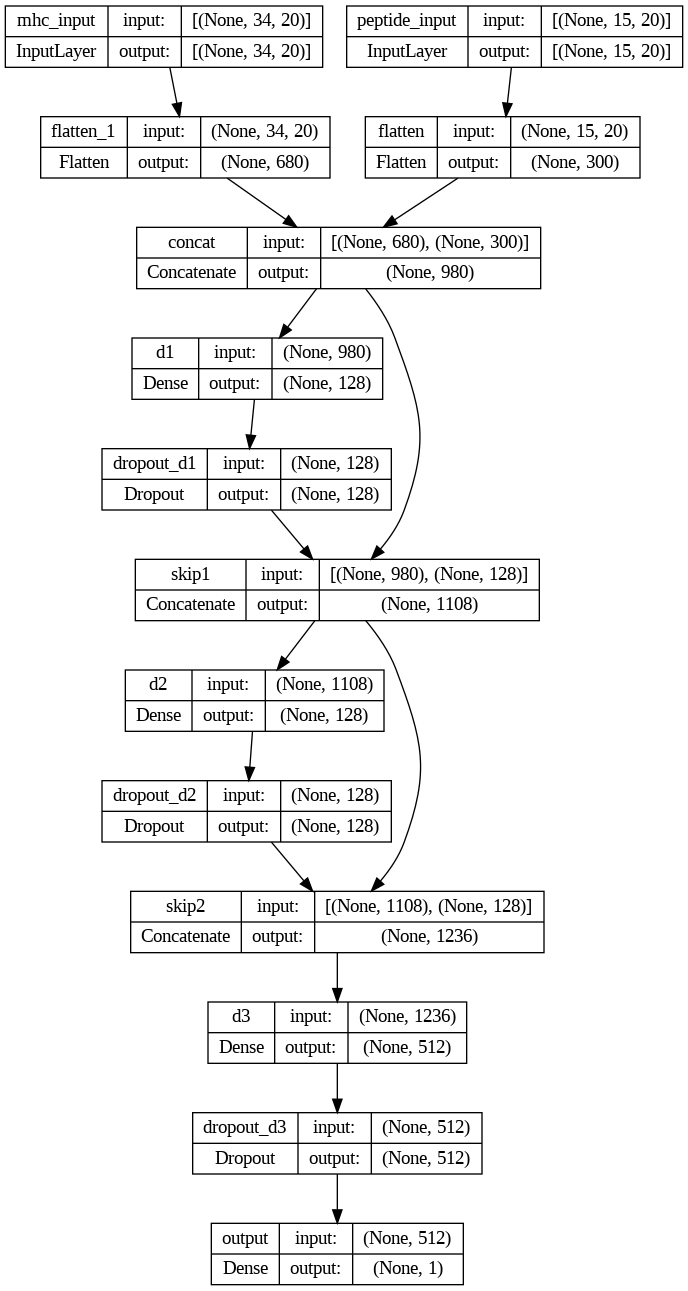

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

## Recompile Model

In [29]:
# Neptune
model_1_optimizer_params = {"learning_rate": 0.0011339304,
                            "momentum": 0.5,
                            "epsilon": 6.848580326162904e-07,
                            "centered": True,
                            "optimizer_type": "RMSprop"}

run["model/optimizer_params"] = model_1_optimizer_params

In [30]:
from tensorflow.keras import optimizers, losses
optimizer = optimizers.RMSprop(
    learning_rate=model_1_optimizer_params["learning_rate"],
    momentum=model_1_optimizer_params["momentum"],
    epsilon=model_1_optimizer_params["epsilon"],
    centered=model_1_optimizer_params["centered"])

#### Remove later
Make RMSE

In [31]:
from tensorflow.keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [32]:
# Neptune
model_1_compiler_params = {"optimizer": "RMSprop",
                           "loss": "inequality_loss.MSEWithInequalities().loss",
                           "metrics": ["mean_absolute_error", "mean_squared_error", "root_mean_squared_error"]}

# Converts list into correct format.
model_1_compiler_params["metrics"] = json.dumps(model_1_compiler_params["metrics"])
run["model/compiler_params"] = model_1_compiler_params

### Compile

In [33]:
model_1.compile(optimizer=optimizer, loss=inequality_loss.MSEWithInequalities().loss, metrics=["mean_absolute_error", "mean_squared_error", root_mean_squared_error])

## Train the Model

In [34]:
# Neptune
training_specs = {"batch_size": 10000,
                  "epochs": 300,
                  "shuffle": True,
                  "verbose": 1,
                  "mhc_callbacks": ["monitor=val_loss", "patience=20", "mode=min", "baseline=1", "min_delta=0.0001"],
                  "early_stopping": True,
                  "num_training_samples": 5000,
                  "num_es_samples": 5000}

# Converts list into correct format.
training_specs["mhc_callbacks"] = json.dumps(training_specs["mhc_callbacks"])

# Neptune
run["training/training_specs"] = training_specs

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.callbacks as Callbacks

mhcglobe_callbacks = [Callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min',
                baseline=1,
                min_delta=0.0001)]

In [36]:
verbose = 1
history = model_1.fit(X_tr, Y_tr,
                        batch_size= 10000, #hparams['batch_size'], 10000
                        epochs=300,
                        validation_data=(X_es, Y_es),
                        shuffle=True,
                        verbose=verbose,
                        callbacks=mhcglobe_callbacks)

Epoch 1/300
59/59 [==============================] - 7s 39ms/step - loss: 1210.4589 - mean_absolute_error: 0.1243 - mean_squared_error: 0.0324 - root_mean_squared_error: 0.1793 - val_loss: 160.6247 - val_mean_absolute_error: 0.1110 - val_mean_squared_error: 0.0280 - val_root_mean_squared_error: 0.1656
Epoch 2/300
59/59 [==============================] - 1s 21ms/step - loss: 155.8391 - mean_absolute_error: 0.1130 - mean_squared_error: 0.0282 - root_mean_squared_error: 0.1680 - val_loss: 152.7489 - val_mean_absolute_error: 0.1051 - val_mean_squared_error: 0.0262 - val_root_mean_squared_error: 0.1603
Epoch 3/300
59/59 [==============================] - 1s 21ms/step - loss: 155.2222 - mean_absolute_error: 0.1089 - mean_squared_error: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 157.9397 - val_mean_absolute_error: 0.1011 - val_mean_squared_error: 0.0247 - val_root_mean_squared_error: 0.1557
Epoch 4/300
59/59 [==============================] - 1s 21ms/step - loss: 154.7111 - mean_abs

### Save with Neptune!

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

In [38]:
for i in range(len(loss)):
    run["training/loss"].append(loss[i])
    run["training/val_loss"].append(val_loss[i])
    run["training/mae"].append(mae[i])
    run["training/val_mae"].append(val_mae[i])
    run["training/mse"].append(mse[i])
    run["training/val_mse"].append(val_mse[i])
    run["training/rmse"].append(rmse[i])
    run["training/val_rmse"].append(val_rmse[i])

## Predict using this model!!!

In [44]:
X = seqf.get_XY(testing_data, encode_type="ONE_HOT", get_Y=False)

In [45]:
test_predictions = model_1.predict(X)

4/4 [==============================] - 0s 2ms/step


In [46]:
prediction_df = phf.get_prediction_df(model_1, X, testing_data)

4/4 [==============================] - 0s 3ms/step


In [47]:
prediction_df

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-A*02:06,RVVDYLTKL,<,100.0,123.493333,0.554872
1,HLA-B*27:05,TRYQTFVNF,<,100.0,110.772376,0.564919
2,HLA-A*02:12,AARHKHQVM,>,20000.0,12768.696607,0.126160
3,HLA-B*07:02,IPRSILMTTF,<,100.0,96.957627,0.577230
4,HLA-B*27:05,SRVMDFFRR,<,100.0,121.536117,0.556348
...,...,...,...,...,...,...
95,HLA-C*15:02,RIHDIAVQL,=,196.0,109.273339,0.566179
96,HLA-A*11:01,ALERLLSLKK,=,822.0,126.008286,0.553009
97,HLA-B*27:09,HRVSQDGLNL,<,100.0,80.437047,0.594495
98,HLA-B*57:03,SSSALVSSLHL,<,100.0,70.186948,0.607093


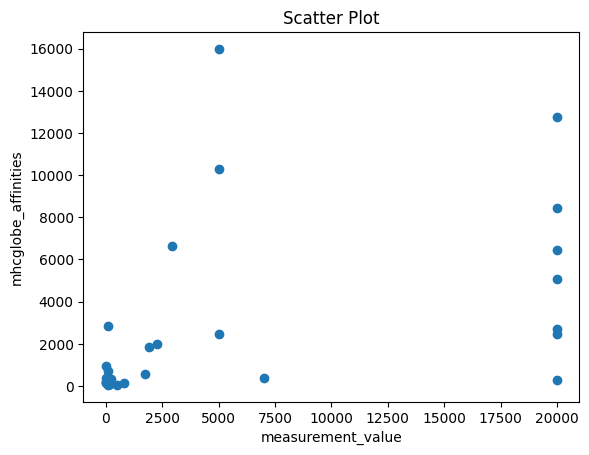

In [63]:
phf.make_scatter_plot(prediction_df, "measurement_value", "mhcglobe_affinities")

In [64]:
predictions_r, predictions_mse = phf.get_r_squared_mse(prediction_df, "measurement_value", "mhcglobe_affinities")
print("R-squared:", predictions_r)
print("MSE:", predictions_mse)

R-squared: 0.3451662337474985
MSE: 18119132.769646104


### Save the Predictions

In [48]:
run["testing/OneHot_test_predictions_428364_24_04_05"].upload(File.as_pickle(test_predictions))
run["testing/OneHot_test_predictions_df_all_428364_24_04_05"].upload(File.as_pickle(prediction_df))

In [50]:
run["testing/OneHot_test_predictions_df_all_viz_428364_24_04_05"].upload(File.as_html(prediction_df))

## Set up Model

In [55]:
key = "ONEHOT1"

model = neptune.init_model(
    project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    key=key
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/m/MHCBER-ONEHOT1


In [62]:
model["run_id"] = run["sys/id"].fetch()
model["num_training_samples"] = train.shape[0]
model["num_es_samples"] = es.shape[0]
model["model/model_1_tf_graph"].upload("/content/model_1.png")
model["optimizer_params"] = model_1_optimizer_params
model["compiler_params"] = model_1_compiler_params